In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *
import ast

In [2]:
PATH = Path('../data/quickdraw/')

In [3]:
PATH.ls()

[PosixPath('../data/quickdraw/test_simplified.csv'),
 PosixPath('../data/quickdraw/itemlist'),
 PosixPath('../data/quickdraw/train'),
 PosixPath('../data/quickdraw/data_bunch'),
 PosixPath('../data/quickdraw/submission'),
 PosixPath('../data/quickdraw/train_folders'),
 PosixPath('../data/quickdraw/valid_folders'),
 PosixPath('../data/quickdraw/train_dummy_folders'),
 PosixPath('../data/quickdraw/dfs_combined.csv'),
 PosixPath('../data/quickdraw/classes.pkl'),
 PosixPath('../data/quickdraw/test')]

### Check Data

In [4]:
train_folders = (PATH/'train_folders').ls()

In [5]:
valid_folders = (PATH/'valid_folders').ls()

In [6]:
len(train_folders), len(valid_folders)

(340, 340)

In [7]:
for p in valid_folders:
     print(p.name, len(p.ls()))

horse 101
flamingo 100
wheel 100
spreadsheet 100
sun 100
mosquito 100
train 100
pig 100
hot_air_balloon 100
tiger 100
skull 100
mouse 100
asparagus 100
snowflake 100
butterfly 100
scissors 100
axe 100
eraser 100
floor_lamp 100
frog 100
purse 100
campfire 100
key 100
string_bean 100
sleeping_bag 100
crocodile 100
envelope 100
television 100
drums 100
castle 100
stairs 100
bed 100
broom 100
map 100
teapot 100
stethoscope 100
stop_sign 100
cloud 100
traffic_light 100
drill 100
crab 100
guitar 100
skateboard 100
monkey 100
bus 100
pineapple 100
whale 100
leg 100
mouth 100
tennis_racquet 100
steak 100
barn 100
toothpaste 100
swan 100
pants 100
airplane 100
hourglass 100
face 100
saxophone 100
squiggle 100
anvil 100
cannon 100
matches 100
soccer_ball 100
sock 100
helmet 100
camera 100
hockey_puck 100
belt 100
chair 100
picture_frame 100
eyeglasses 100
raccoon 100
flying_saucer 100
owl 100
teddy-bear 100
peas 100
beard 100
sandwich 100
tornado 100
potato 100
ear 100
basket 100
square 100
divi

../data/quickdraw/train_folders/bear/img_25518.png


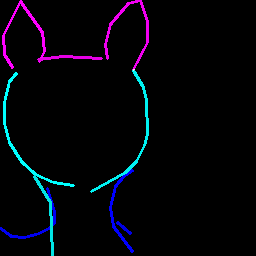

In [8]:
# show random training image
i = np.random.choice(range(len(train_folders)))
rand_img_path = np.random.choice(train_folders[i].ls())
print(rand_img_path)
open_image(rand_img_path)

../data/quickdraw/train_folders/crab/img_34649.png


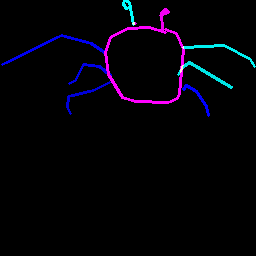

In [9]:
# show random training image
i = np.random.choice(range(len(valid_folders)))
rand_img_path = np.random.choice(train_folders[i].ls())
print(rand_img_path)
open_image(rand_img_path)

../data/quickdraw/test/9381021648116487.png


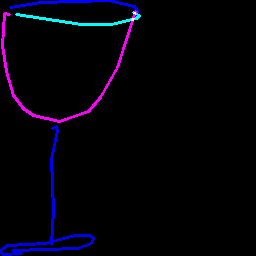

In [10]:
test_folder = (PATH/'test')
rand_img_path = np.random.choice(test_folder.ls())
print(rand_img_path)
open_image(rand_img_path)

### DataBunch v2

In [11]:
from collections import defaultdict
class Splitter(object):
    def __init__(self, valid_sz=100):
        self.class_counts = defaultdict(int)
        self.valid_sz = valid_sz
        
    def split(self, item):
        c = item.parent.name
        if self.class_counts[c] < self.valid_sz:
            self.class_counts[c] += 1
            return True
        else: return False

In [12]:
#itemlist = ImageItemList.from_folder(PATH/"train_folders")
#pd.to_pickle(itemlist, PATH/"itemlist")

In [13]:
itemlist = pd.read_pickle(PATH/"itemlist")

In [14]:
splitter = Splitter(valid_sz=100)
itemlists = itemlist.split_by_valid_func(splitter.split)              

In [15]:
labellists = itemlists.label_from_folder()

In [16]:
test_items = ImageItemList.from_folder(PATH/'test')

In [17]:
labellists = labellists.add_test(test_items)

In [18]:
tfms = get_transforms(do_flip=True, max_rotate=15, max_zoom=1.1, max_warp=0, 
                      max_lighting=0, p_affine=0.5, p_lighting=0)

In [19]:
labellists = labellists.transform(tfms=tfms, size=256)

In [20]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

class RandomSamplerWithEpochSize(Sampler):
    """Yields epochs of specified sizes. Iterates over all examples in a data_source in random
    order. Ensures (nearly) all examples have been trained on before beginning the next iteration
    over the data_source - drops the last epoch that would likely be smaller than epoch_size.
    """
    def __init__(self, data_source, epoch_size):
        self.n = len(data_source)
        self.epoch_size = epoch_size
        self._epochs = []
    def __iter__(self):
        return iter(self.next_epoch)
    @property
    def next_epoch(self):
        if len(self._epochs) == 0: self.generate_epochs()
        return self._epochs.pop()
    def generate_epochs(self):
        idxs = [i for i in range(self.n)]
        np.random.shuffle(idxs)
        self._epochs = list(chunks(idxs, self.epoch_size))[:-1]
    def __len__(self):
        return self.epoch_size

In [21]:
bs=300
epoch_size = 3_000_000

train_dl = DataLoader(labellists.train, num_workers=8,
    batch_sampler=BatchSampler(RandomSamplerWithEpochSize(labellists.train, epoch_size),
                               bs, True))

valid_dl = DataLoader(labellists.valid, bs, False, num_workers=8)

test_dl = DataLoader(labellists.test, bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [22]:
len(data_bunch.train_ds), len(data_bunch.valid_ds), len(data_bunch.test_ds)

(33486525, 34000, 112199)

In [23]:
# classes = data_bunch.classes
# pd.to_pickle(classes, PATH/"classes.pkl")

### Model - Train

In [24]:
name = 'resnet34'

In [25]:
from fastai.callbacks import SaveModelCallback
import sys

In [26]:
learn = create_cnn(data_bunch, arch=models.resnet34, metrics=[accuracy, map3])

In [30]:
learn.load("resnet34-stage-2-128");

In [31]:
learn.freeze()

In [33]:
learn.fit_one_cycle(cyc_len=10, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,map3


RuntimeError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 0; 15.78 GiB total capacity; 13.46 GiB already allocated; 903.94 MiB free; 429.85 MiB cached)

### Predict

In [21]:
learn.data.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f7b046602e8>, device=device(type='cuda'), tfms=[[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True), RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10, 10)}, p=0.75, resolved={}, do_run=True, is_random=True)], [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]], collate_fn=<function data_collate at 0x7f7b2c749620>, skip_size1=False)

In [40]:
# 100 examples for each class as valid
Counter([item.parent.name for item in itemlists.valid.items])

Counter({'horse': 100,
         'flamingo': 100,
         'wheel': 100,
         'spreadsheet': 100,
         'sun': 100,
         'mosquito': 100,
         'train': 100,
         'pig': 100,
         'hot_air_balloon': 100,
         'tiger': 100,
         'skull': 100,
         'mouse': 100,
         'asparagus': 100,
         'snowflake': 100,
         'butterfly': 100,
         'scissors': 100,
         'axe': 100,
         'eraser': 100,
         'floor_lamp': 100,
         'frog': 100,
         'purse': 100,
         'campfire': 100,
         'key': 100,
         'string_bean': 100,
         'sleeping_bag': 100,
         'crocodile': 100,
         'envelope': 100,
         'television': 100,
         'drums': 100,
         'castle': 100,
         'stairs': 100,
         'bed': 100,
         'broom': 100,
         'map': 100,
         'teapot': 100,
         'stethoscope': 100,
         'stop_sign': 100,
         'cloud': 100,
         'traffic_light': 100,
         'drill': 100,
 

In [96]:
itemlists.valid

LabelList
y: CategoryList (34000 items)
[Category horse, Category horse, Category horse, Category horse, Category horse]...
Path: .
x: ImageItemList (34000 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../data/quickdraw/train_folders

In [214]:
data_bunch.test_dl.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]

In [22]:
from utils import create_submission

In [23]:
sorted(Path('../quickdraw/models').ls())[:5]

[PosixPath('../quickdraw/models/final-mobilenet-stage-1.pth'),
 PosixPath('../quickdraw/models/final-mobilenet-stage-2.pth'),
 PosixPath('../quickdraw/models/final-senet-stage-1.pth'),
 PosixPath('../quickdraw/models/senet_1.pth'),
 PosixPath('../quickdraw/models/senet_10.pth')]

In [71]:
model_ckpt = "senet_19"

In [72]:
learn = learn.load(model_ckpt)

In [73]:
learn.data.test_dl.tfms = None

In [74]:
preds, _ = learn.get_preds(DatasetType.Test)

In [75]:
sub_name = f"{model_ckpt}"

In [76]:
def top_3_preds(preds): return np.argsort(preds.numpy())[:, ::-1][:, :3]

def top_3_pred_labels(preds, classes):
    top_3 = top_3_preds(preds)
    labels = []
    for i in range(top_3.shape[0]):
        labels.append(' '.join([classes[idx].replace(" ", "_") for idx in top_3[i]]))
    return labels
    
def create_submission(test_preds, test_dl, name, classes):
    key_ids = [path.stem for path in test_dl.dataset.x.items]
    labels = top_3_pred_labels(test_preds, classes)
    sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
    sub.to_csv(f'{PATH}/submission/{name}.csv.gz', index=False, compression='gzip')

In [77]:
create_submission(preds, test_dl, sub_name, classes)

In [78]:
sub_name

'senet_19'

In [79]:
len(test_items)

112199

In [80]:
pd.read_csv(f'../data/quickdraw/submission/{sub_name}.csv.gz').head(10)

,key_id,word
0,9736539586575506,horse frog bear
1,9156420504855747,skull mushroom bread
2,9725934544390889,sink flamingo mailbox
3,9903565523633750,trombone trumpet megaphone
4,9507032565495870,tennis_racquet fan microphone
5,9035256546065251,flower tree broccoli
6,9494182684488699,snowman bear frog
7,9280101504435248,camel horse dragon
8,9955106400063151,necklace goatee parachute
9,9912795502728975,cactus mosquito dragon


In [81]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f '../data/quickdraw/submission/{sub_name}.csv.gz' -m "{sub_name}"

100%|██████████████████████████████████████| 1.53M/1.53M [00:01<00:00, 1.47MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

In [161]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]

In [112]:
itemlists.train[0]

(Image (3, 256, 256), Category horse)

In [154]:
np.unique(x.data[0])

array([0.      , 0.94902 , 0.996078, 1.      ], dtype=float32)

In [149]:
listify(data_bunch.tfms)[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15, 15)}, p=0.5, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.5, resolved={}, do_run=True, is_random=True)]

In [137]:
# sys.path.append("pytorch-mobilenet-v2/")
# from MobileNetV2 import MobileNetV2

# sys.path.append("./senet.pytorch/")
# from se_resnet import se_resnet50
# model = se_resnet50(340)
# learn = Learner(data_bunch, model, metrics=[accuracy, map3],
#                 callback_fns=[partial(SaveModelCallback, every="epoch", name="senet")])

In [20]:
sys.path.append("./senet.pytorch/")
from se_resnet import se_resnet50
model = se_resnet50(340)
learn = Learner(data_bunch, model, metrics=[accuracy, map3],
                callback_fns=[partial(SaveModelCallback, every="epoch", name="senet")])

In [117]:
x,y = next(iter(data_bunch.test_dl))

In [14]:
data_bunch.tfms

[[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10, 10)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]]

In [13]:
train_dl = DataLoader(
    label_lists.train,
    num_workers=8,
    batch_sampler=BatchSampler(RandomSamplerWithEpochSize(label_lists.train, 1_000_000), bs, True)
)
valid_dl = DataLoader(label_lists.valid, bs, False, num_workers=8)
test_dl = DataLoader(label_lists.test, bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl, tfms=tfms)

In [12]:
70000*340/1000000

23.8

In [11]:
tfms = get_transforms(do_flip=True, flip_vert=False, 
                      max_rotate=10, max_zoom=0, max_lighting=None, max_warp=None)

In [10]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

class RandomSamplerWithEpochSize(Sampler):
    """Yields epochs of specified sizes. Iterates over all examples in a data_source in random
    order. Ensures (nearly) all examples have been trained on before beginning the next iteration
    over the data_source - drops the last epoch that would likely be smaller than epoch_size.
    """
    def __init__(self, data_source, epoch_size):
        self.n = len(data_source)
        self.epoch_size = epoch_size
        self._epochs = []
    def __iter__(self):
        return iter(self.next_epoch)
    @property
    def next_epoch(self):
        if len(self._epochs) == 0: self.generate_epochs()
        return self._epochs.pop()
    def generate_epochs(self):
        idxs = [i for i in range(self.n)]
        np.random.shuffle(idxs)
        self._epochs = list(chunks(idxs, self.epoch_size))[:-1]
    def __len__(self):
        return self.epoch_size

In [9]:
item_list = ItemList.from_folder(PATH/"dummy_train_folders", create_func=create_func)
np.random.seed(42)
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
item_lists = item_list.split_by_idx(val_idxs)
label_lists = item_lists.label_from_folder()
test_items = ItemList.from_folder(PATH/"test", create_func=create_func)
label_lists.add_test(test_items);

In [8]:
def create_func(item):
    with open(item) as f: item = f.read()
    img = list2drawing(json.loads(item)['data'], size=sz, lw=4, time_color=True)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    tensor = torch.from_numpy(img).float()
    return Image(tensor.permute((2,0,1)).div_(255))

In [7]:
bs = 100
sz = 256

### Create ImageDataBunch using the data block API

### data

In [6]:
dfs_combined = pd.read_csv(PATH/"dfs_combined.csv")
dfs_combined = dfs_combined[['drawing', 'word']]

In [7]:
dfs_combined['word'] = dfs_combined['word'].apply(lambda x: x.replace(" ", "_"))

In [8]:
dfs_combined.head()

,drawing,word
0,"[[[47, 41, 40, 9, 3, 0, 0, 9, 11, 17, 23, 31, ...",wine_bottle
1,"[[[10, 51, 62, 58, 60, 65, 87, 100, 96, 92, 80...",wine_bottle
2,"[[[45, 43, 35, 14, 5, 1, 7, 49, 100, 117, 117,...",wine_bottle
3,"[[[75, 56, 47, 42, 46, 55, 70, 82, 80, 75], [4...",wine_bottle
4,"[[[19, 9, 1, 3, 9, 21, 39, 47, 68, 84, 89, 88,...",wine_bottle


In [9]:
dfs_combined.shape

(33976415, 2)

In [10]:
def get_raw_stroke_parts(raw_strokes):
    if isinstance(raw_strokes, str): raw_strokes = eval(raw_strokes)
    n = len(raw_strokes)
    if n == 1:
        return [[raw_strokes[0]], None, None]
    elif n == 2:
        return [[raw_strokes[0]], [raw_strokes[1]], None]
    else:
        div, _ = divmod(n, 3)
        return [raw_strokes[:div], raw_strokes[div:div*2], raw_strokes[div*2:]]
    
def list2drawing(raw_strokes, size=256, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

def raw_stroke_parts2drawing(raw_stroke_parts, sum_as_final=True, color=True):
    img = []
    for raw_stroke in raw_stroke_parts:
        if raw_stroke is not None:
            img.append(list2drawing(raw_stroke, 256, lw=2, time_color=color))
        else:
            img.append(np.zeros((256, 256)))
    if sum_as_final:
        img[2] = img[0] + img[1] + img[2]
    return np.array(img)

def list2drawing_3channels(raw_strokes, sum_as_final=True, color=True):
    img_arr = raw_stroke_parts2drawing(get_raw_stroke_parts(raw_strokes), sum_as_final, color)
    img_arr = np.rollaxis(img_arr, 0, 3)
    return Image(pil2tensor(img_arr, dtype=np.float32).div_(255))

In [11]:
%%timeit
raw_stroke_parts2drawing(dfs_combined['drawing'][0])

The slowest run took 40.53 times longer than the fastest. This could mean that an intermediate result is being cached.
15.8 ms ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


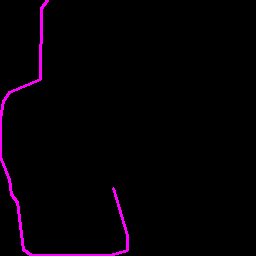

In [12]:
list2drawing_3channels(dfs_combined['drawing'][0])

In [13]:
dfs_combined.head()

,drawing,word
0,"[[[47, 41, 40, 9, 3, 0, 0, 9, 11, 17, 23, 31, ...",wine_bottle
1,"[[[10, 51, 62, 58, 60, 65, 87, 100, 96, 92, 80...",wine_bottle
2,"[[[45, 43, 35, 14, 5, 1, 7, 49, 100, 117, 117,...",wine_bottle
3,"[[[75, 56, 47, 42, 46, 55, 70, 82, 80, 75], [4...",wine_bottle
4,"[[[19, 9, 1, 3, 9, 21, 39, 47, 68, 84, 89, 88,...",wine_bottle


In [14]:
valid_idx = list(dfs_combined.groupby("word").head(100).index)
train_labels = dfs_combined[~dfs_combined.index.isin(valid_idx)]['word']
valid_labels = dfs_combined[dfs_combined.index.isin(valid_idx)]['word']
train_labels = list(train_labels)
valid_labels = list(valid_labels)

In [ ]:
itemlist = ItemList.from_df(df=dfs_combined, cols=['drawing'],
                            create_func=list2drawing_3channels).\
split_by_idx(list(valid_idx)).\
label_from_lists(train_labels, valid_labels)

In [119]:
classes

['horse',
 'flamingo',
 'wheel',
 'spreadsheet',
 'sun',
 'mosquito',
 'train',
 'pig',
 'hot_air_balloon',
 'tiger',
 'skull',
 'mouse',
 'asparagus',
 'snowflake',
 'butterfly',
 'scissors',
 'axe',
 'eraser',
 'floor_lamp',
 'frog',
 'purse',
 'campfire',
 'key',
 'string_bean',
 'sleeping_bag',
 'crocodile',
 'envelope',
 'television',
 'drums',
 'castle',
 'stairs',
 'bed',
 'broom',
 'map',
 'teapot',
 'stethoscope',
 'stop_sign',
 'cloud',
 'traffic_light',
 'drill',
 'crab',
 'guitar',
 'skateboard',
 'monkey',
 'bus',
 'pineapple',
 'whale',
 'leg',
 'mouth',
 'tennis_racquet',
 'steak',
 'barn',
 'toothpaste',
 'swan',
 'pants',
 'airplane',
 'hourglass',
 'face',
 'saxophone',
 'squiggle',
 'anvil',
 'cannon',
 'matches',
 'soccer_ball',
 'sock',
 'helmet',
 'camera',
 'hockey_puck',
 'belt',
 'chair',
 'picture_frame',
 'eyeglasses',
 'raccoon',
 'flying_saucer',
 'owl',
 'teddy-bear',
 'peas',
 'beard',
 'sandwich',
 'tornado',
 'potato',
 'ear',
 'basket',
 'square',
 'di

In [17]:
classes[:10]

['horse',
 'flamingo',
 'wheel',
 'spreadsheet',
 'sun',
 'mosquito',
 'train',
 'pig',
 'hot_air_balloon',
 'tiger']

In [114]:
len(itemlists.train)

33520526

In [93]:
data.tes

IndexError: index 0 is out of bounds for axis 0 with size 0

In [92]:
data.valid_ds[0]

(Image (3, 256, 256), Category horse)